In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

/opt/miniconda3/envs/mamografia/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
ruta_DE2_train = '/Users/claracelestechavezcotrina/Downloads/DATA_TESIS/datasetPublico_preprocesado_etapa2/train'
ruta_DE2_val = '/Users/claracelestechavezcotrina/Downloads/DATA_TESIS/datasetPublico_preprocesado_etapa2/val'
ruta_DE2_test = '/Users/claracelestechavezcotrina/Downloads/DATA_TESIS/datasetPublico_preprocesado_etapa2/test'

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 8   # pequeño por la escasez de datos
NUM_CLASSES = 3

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [8]:
train_gen = train_datagen.flow_from_directory(
    ruta_DE2_train,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    ruta_DE2_val,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = test_datagen.flow_from_directory(
    ruta_DE2_test,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 86 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Found 17 images belonging to 3 classes.


In [9]:
print(train_gen.class_indices)

{'birads3': 0, 'birads4': 1, 'birads5': 2}


In [10]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_train = train_gen.classes

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.7916666666666667, 1: 0.9555555555555556, 2: 0.7166666666666667}


In [11]:
base_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

2026-01-13 22:56:59.782273: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2026-01-13 22:56:59.782482: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2026-01-13 22:56:59.782492: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2026-01-13 22:56:59.783085: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-13 22:56:59.783729: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc", multi_label=True),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

In [14]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=4,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        "densenet121_etapa2_birads3_4_5.keras",
        monitor="val_loss",
        save_best_only=True
    )
]

In [15]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/40


2026-01-13 22:58:11.077714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3605 - auc: 0.4839 - loss: 2.3513 - precision: 0.3647 - recall: 0.3605 - val_accuracy: 0.5000 - val_auc: 0.7023 - val_loss: 0.9464 - val_precision: 0.5385 - val_recall: 0.3500 - learning_rate: 1.0000e-04
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.4070 - auc: 0.5303 - loss: 1.8721 - precision: 0.4103 - recall: 0.3721 - val_accuracy: 0.4000 - val_auc: 0.7285 - val_loss: 1.0645 - val_precision: 0.6154 - val_recall: 0.4000 - learning_rate: 1.0000e-04
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.2326 - auc: 0.4749 - loss: 2.0621 - precision: 0.2597 - recall: 0.2326 - val_accuracy: 0.5000 - val_auc: 0.7132 - val_loss: 1.0878 - val_precision: 0.5000 - val_recall: 0.3000 - learning_rate: 1.0000e-04
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - accuracy: 0.2907 - auc: 0.5095 - loss: 1.8084 - precision: 0.2800 - recall: 0.2442 - val_accuracy: 0.3500 - val_auc: 0.6939 - val_loss: 1.2485 - val_

In [16]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_gen.classes
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step 


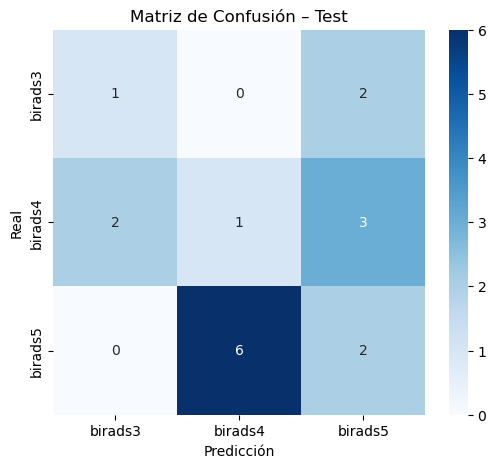

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=test_gen.class_indices.keys(),
    yticklabels=test_gen.class_indices.keys()
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión – Test")
plt.show()

In [19]:
print(classification_report(
    y_true,
    y_pred,
    target_names=test_gen.class_indices.keys()
))


              precision    recall  f1-score   support

     birads3       0.33      0.33      0.33         3
     birads4       0.14      0.17      0.15         6
     birads5       0.29      0.25      0.27         8

    accuracy                           0.24        17
   macro avg       0.25      0.25      0.25        17
weighted avg       0.24      0.24      0.24        17

